# Task 1
Consider a subset of the MNIST hand-written images which consists of the first 1000 images for digits 0 and 2. Each image is of size 28 × 28, and is transformed by Gabor wavelets to extract features at different orientations and scales. This results in an array of size 28 × 28 × 8 × 4 for each image, or equivalently, a matrix F of size 784 × 32. Each column of F corresponds to a different view of the image.
The goal of this assignment is to perform linear regression on the MNIST images, and classify them as either 0 or 2. The input variables are the features extracted by the Gabor wavelets, and the output variable is the label of the image.

100%|██████████| 9912422/9912422 [00:00<00:00, 77431120.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 57437503.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29572278.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1536085.21it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



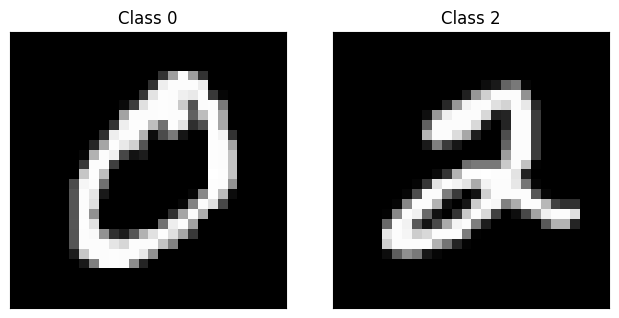

Shape of matrix X: (2000, 28, 28)
Len of y: 2000


100%|██████████| 2000/2000 [06:25<00:00,  5.19it/s]


Shape of matrix X_gabor: (2000, 28, 28, 8, 4)


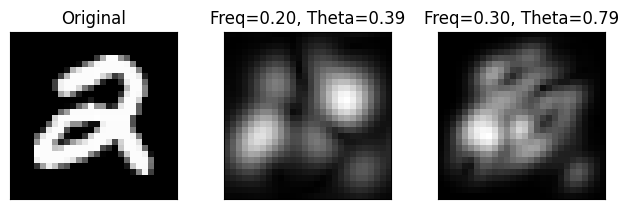

In [ ]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from tqdm import tqdm

# load dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=Normalize((0.1307,), (0.3081,)))

X = np.empty((0, 28, 28))
y = np.empty(0)
labels = [0, 2]

# display dataset
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.tight_layout()
  plt.imshow(mnist_trainset.data[mnist_trainset.targets==labels[i]][0], cmap='gray', interpolation='none')
  plt.title(f"Class {labels[i]}")
  plt.xticks([])
  plt.yticks([])
plt.show()

# filter labels and cut to 1000 samples
labels = [0, 2]
for label in labels:
  idx = (mnist_trainset.targets==label)
  y = np.append(y, mnist_trainset.targets[idx][:1000].numpy())
  X = np.vstack((X, mnist_trainset.data[idx][:1000].numpy()))

print('Shape of matrix X:', X.shape)
print('Len of y:', len(y))

# Gabor Transform
frequencies = [.1, .2, .3, .4]
thetas = np.arange(0, np.pi, np.pi / 8)

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

X_gabor = np.empty((0, 28, 28, 8, 4))
for x in tqdm(X):
  x_gabor = np.empty((1, 28, 28, 8, 4))
  for i, theta in enumerate(thetas):
    for j, frequency in enumerate(frequencies):
      kernel = gabor_kernel(frequency=frequency, theta=theta)
      x_gabor[:,:,:,i,j] = power(x, kernel)
  X_gabor = np.vstack((X_gabor, x_gabor))

print('Shape of matrix X_gabor:', X_gabor.shape)

ex_idx = 1500
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(X[ex_idx], cmap='gray', interpolation='none')
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.title(f"Original")
for i in range(1, 3):
  plt.subplot(1,3,i+1)
  plt.tight_layout()
  plt.imshow(X_gabor[ex_idx][:,:, i, i], cmap='gray', interpolation='none')
  plt.title(f"Freq={frequencies[i]:.2f}, Theta={thetas[i]:.2f}")
  plt.xticks([])
  plt.yticks([])
plt.show()

[link text](https://)#### Part 1: **Basic linear regression**

Let $x_k$ be the $m$-th view features of the $k$-th image, i.e., the $m$-th column of $F_k$. Let $y_k$ be the label of the $k$-th image. Solve the following linear regression problem:
$$\min_{w} \sum^K_{k=1} (y_k - x_k^Tw)^2$$
where $K$ is the number of images in the subset. Report the classification accuracy for 10-fold cross-validation, where the subset is randomly divided into 10 equal parts, and each part is used as a test set once, while the remaining parts are used as a training set.

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold

numFolds = 10
c = StratifiedKFold(n_splits=numFolds, shuffle=True, random_state=42) # use scikit-learn's StratifiedKFold for cross-validation



In [ ]:
# For cross-validation
def crossval_test(F, true_labels, fextr, c, verbose):
  # StratifiedKFold for cross-validation
  # F is the data matrix samples x feature length
  # true_labels : array of true labels
  # w = fextr(X,y) : train feature extraction y = X @ w

  # initialize an empty list for performance array
  perfAry = []
  # initialize an array for predicted labels
  YPredAry = np.zeros(len(true_labels))

  # Crossvalidation
  for kf, (trIdx, teIdx) in enumerate(c.split(F, true_labels)): # loop over the cross-validation folds

    # get Train and Test data for this fold
    xTrain = F[trIdx]
    yTrain = true_labels[trIdx]
    xTest = F[teIdx]
    yTest = true_labels[teIdx]

    w = fextr(xTrain, yTrain) # extract features from X

    YtrPred = xTrain @ w # use @ operator for matrix multiplication
    YtsPred = xTest @ w

    # train a discriminant classifier
    Mdl = LinearDiscriminantAnalysis() # use scikit-learn's LinearDiscriminantAnalysis for discriminant analysis
    Mdl.fit(YtrPred.reshape(-1, 1), yTrain) # reshape YtrPred to a column vector

    # get prediction
    YPred = Mdl.predict(YtsPred.reshape(-1, 1)) # reshape YtsPred to a column vector
    acc = np.mean(YPred == yTest) # calculate accuracy
    YPredAry[teIdx] = YPred # assign predicted labels to the corresponding indices

    perfAry.append(acc) # append accuracy to the performance array
    if verbose!=0:
      print(f'kf {kf+1}, acc {acc}') # print the fold number and accuracy

  # return the performance array and the predicted labels array
  return perfAry, YPredAry

In [ ]:
# view index
m = 2
X_gabor = X_gabor.reshape(2000, 28*28, 32)
F = X_gabor[:,:,m]

# remapping labels to -1 and 1
true_labels = np.where(y==0, -1, 1)

# Linear regression
fextr = lambda X, y: np.linalg.lstsq(X, y, rcond=None)[0] # use numpy's lstsq function for linear least squares

perfAry_ls, YPred_ls = crossval_test(F, true_labels, fextr, c,verbose = 1)

kf 1, acc 0.92
kf 2, acc 0.92
kf 3, acc 0.92
kf 4, acc 0.93
kf 5, acc 0.875
kf 6, acc 0.925
kf 7, acc 0.92
kf 8, acc 0.9
kf 9, acc 0.91
kf 10, acc 0.93


In [ ]:
print(np.mean(perfAry_ls))

0.915


**Check performance for all views**

  

In [ ]:
numviews = X_gabor.shape[2]
perfAry_ls_allviews = []
fextr = lambda X, y: np.linalg.lstsq(X, y, rcond=None)[0] # use numpy's lstsq function for linear least squares

for m in range(numviews):
  F = X_gabor[:,:,m]

  F = X_gabor[:,:,m]

  # Linear regression
  perfAry_ls_, YPred_ls_ = crossval_test(F, true_labels, fextr, c, verbose = 0)

  perfAry_ls_allviews.append(np.mean(perfAry_ls_))

print(f'Mean accuracy over 10-fold cross-validation: {np.mean(perfAry_ls_allviews):.2f}')


Mean accuracy over 10-fold cross-validation: 0.92


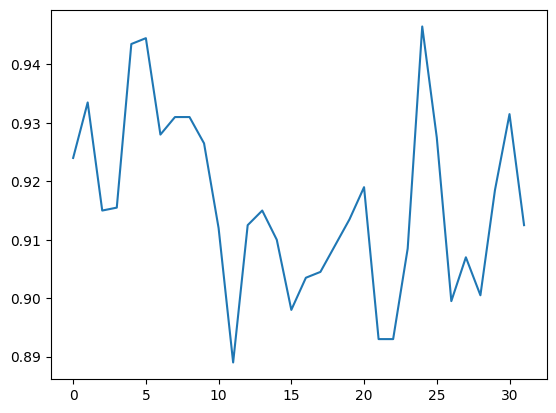

In [ ]:
plt.figure
plt.plot(perfAry_ls_allviews)

#### Part 2: **Robust linear regression**

Consider a variant of linear regression in which the input variables $x_k$ are perturbed by some noise $e_k$ with $||e_k ||_2 ≤ δ$, where $δ$ is a given parameter. The noise $e_k$ represents the uncertainty or variability in the features extracted by the Gabor wavelets.
The task is to seek a weight vector $w$ that minimizes the worst-case error due to the noise $e_k$, i.e.,
$$\min_w \max_{e_k} \sum^K_{k=1} (y_k - (x_k + e_k)^Tw)^2 \\
\text{subject to } ||e_k||^2_2 \le \delta, k=1,\dots,K$$
Simplify the above problem to an unconstrained optimization problem. Solve the simplified problem and report the classification accuracy for 10-fold cross-validation.

Add Gaussian noise with zero mean and standard deviation of $0.01$ to $x_k$. Compare perform of the two linear regression methods for the noisy input data, $x_k$.
Report classification accuracy for all views.

Let's consider sub-problem:
\begin{align}
\max_e \quad &\frac{1}{2}(y-(x+e)^Tw)^2\\
\text{subject to } \quad & ||e||^2_2 \le \delta
\end{align}
Lagrangian associated to the problem

\begin{align}
L &= \frac{1}{2} (y-(x+e)^Tw)^2 + \frac{\lambda}{2} (||e||^2_2 - \delta^2) \\
&= \frac{1}{2} (y-x^Tw - e^Tw)^2 + \frac{\lambda}{2}  (||e||^2_2 - \delta^2)  \\
&= \frac{1}{2} (b -  w^Te)^2 + \frac{\lambda}{2}  (||e||^2_2 - \delta^2)
\end{align}


$$\frac{\partial L}{\partial e} = -w(b-w^Te) + \lambda e = -wb + ww^Te + \lambda e = 0$$
implying that $e^*$ and $w$ are parallel
 $$e^* = \alpha w$$

Taking into account that maximum of a convex function over a convex set is reached on the border of the convex set:
$$||e^*||^2 = \delta^2 \Rightarrow |\alpha| ||w|| = \delta \Rightarrow |\alpha| = \frac{\delta}{||w||}$$
$$e^* = \pm \delta \frac{w}{||w||} = \frac{tw}{||w||}, t = \pm 1$$

Substitute $e^*$ into the loss function and rewrite the maximization problem as
\begin{align}
\max f(w) &=\frac{1}{2} (b-w^Te^*)^2 \\
&= \frac{1}{2}\left(b - t\delta \frac{w^w}{||w||}\right)^2
\end{align}
The maximum achieves when $t^* = -sign(b)$
and the optimal perturbed noise is given by
$$e_k^* = -sign(y_k-w^Tx_k)\delta \frac{w}{||w||}$$

Replacing $e_k^*$ in to the original problem we get
\begin{align}
(y_k - (x_k + e_k^*)^Tw)^2 &= (y_k - (x_k-sign(y_k-w^Tx_k)\delta \frac{w}{||w||})^Tw)^2 \\
&=(y_k - x_k^Tw + sign(y_k-w^Tx_k)\delta ||w||)^2 \\
&= (y_k - x_k^Tw)^2 + 2\delta |y_k-w^Tx_k| ||w|| + \delta^2 ||w||^2 \\
&= (|y_k-w^Tx_k| + \delta ||w||)^2
\end{align}

Reformulating the original constrained problem to a new unconstrained problem:
$$\min_w \sum^K_{k=1} (|y_k-x_k^Tw| + \delta ||w||)^2$$

In [ ]:
def robust_linreg(F,b,delta):
  lenw = F.shape[1]
  numK = F.shape[0]

  w = cp.Variable(lenw)
  objective = cp.Minimize(cp.norm(b - F @ w, 1) + numK*delta*cp.norm(w, 2))
  # objective = cp.Minimize(cp.sum_squares(cp.abs(b_train - F_train[:,:,m] @ w) + delta*cp.norm(w,2)))
  prob = cp.Problem(objective)
  prob.solve()

  return w.value


Robust Linear Regression

In [ ]:
m = 2
X_gabor = X_gabor.reshape(2000, 28*28, 32)
F = X_gabor[:,:,m]

# remapping labels to -1 and 1
true_labels = np.where(y==0, -1, 1)
delta = 0.01

# Linear regression
fextr = lambda X, y: robust_linreg(X, y,delta)

perfAry_robustls, YPred_robustls = crossval_test(F, true_labels, fextr, c)

kf 1, acc 0.97
kf 2, acc 0.975
kf 3, acc 0.97
kf 4, acc 0.985
kf 5, acc 0.94
kf 6, acc 0.98
kf 7, acc 0.97
kf 8, acc 0.945
kf 9, acc 0.935
kf 10, acc 0.965


In [ ]:
print(np.mean(perfAry_robustls))

0.9635


In [ ]:
def robust_linreg2(F,b,delta):
  lenw = F.shape[1]

  w = cp.Variable(lenw)
  objective = cp.Minimize(cp.sum(cp.square(cp.norm(b - F @ w, 1) + delta*cp.norm(w, 2))))
  prob = cp.Problem(objective)
  prob.solve()

  return w.value

In [ ]:
m = 2
X_gabor = X_gabor.reshape(2000, 28*28, 32)
F = X_gabor[:,:,m]

delta = .1

# Linear regression
fextr = lambda X, y: robust_linreg2(X, y,delta)

perfAry_robustls2, YPred_robustls2 = crossval_test(F, true_labels, fextr, c)
print(np.mean(perfAry_robustls2))

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 1, acc 0.945


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 2, acc 0.94


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 3, acc 0.96


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 4, acc 0.93


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 5, acc 0.905


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 6, acc 0.94


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 7, acc 0.92


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 8, acc 0.905


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


kf 9, acc 0.945
kf 10, acc 0.945
0.9335000000000001


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
print(np.mean(perfAry_robustls2))

0.9335000000000001


**Check Robust LinReg for All Views**

In [ ]:
perfAry_robustls_allviews = []
fextr = lambda X, y: robust_linreg(X, y,delta)


d = 0.01

for m in range(numviews):

  F = X_gabor[:,:,m]

  # Linear regression
  perfAry_robustls_, YPred_robustls_ = crossval_test(F, true_labels, fextr, c, verbose = 0)

  perfAry_robustls_allviews.append(np.mean(perfAry_robustls_))
  print(f'Mean accuracy over 10-fold cross-validation: {np.mean(perfAry_robustls_):.2f}')


print(f'Mean accuracy over 10-fold cross-validation: {np.mean(perfAry_robustls_allviews):.2f}')


Mean accuracy over 10-fold cross-validation: 0.96
Mean accuracy over 10-fold cross-validation: 0.97
Mean accuracy over 10-fold cross-validation: 0.96
Mean accuracy over 10-fold cross-validation: 0.96
Mean accuracy over 10-fold cross-validation: 0.98
Mean accuracy over 10-fold cross-validation: 0.97
Mean accuracy over 10-fold cross-validation: 0.96
Mean accuracy over 10-fold cross-validation: 0.97
Mean accuracy over 10-fold cross-validation: 0.97
Mean accuracy over 10-fold cross-validation: 0.96
Mean accuracy over 10-fold cross-validation: 0.96
Mean accuracy over 10-fold cross-validation: 0.96
Mean accuracy over 10-fold cross-validation: 0.97
Mean accuracy over 10-fold cross-validation: 0.94
Mean accuracy over 10-fold cross-validation: 0.94
Mean accuracy over 10-fold cross-validation: 0.94
Mean accuracy over 10-fold cross-validation: 0.96
Mean accuracy over 10-fold cross-validation: 0.94
Mean accuracy over 10-fold cross-validation: 0.94
Mean accuracy over 10-fold cross-validation: 0.94


In [ ]:
import matplotlib.pyplot as plt
plt.figure
plt.plot(perfAry_robustls_allviews)
plt.plot(perfAry_ls_allviews)


**PART 2: Noisy feature Inputs**



In [ ]:
# add noise
delta = 1;
m = 2
F = X_gabor[:,:,m]
N = np.random.normal(loc=.0, scale=1, size=(F.shape))

# calculate the norm of each row of noise components
row_norms = np.linalg.norm (N, ord=2, axis=1, keepdims=True)

# create a diagonal matrix from the inverse of the row norms
D = np.diag (np.reciprocal (row_norms).ravel ())

# scale each row of E to have a unit norm
N = np.matmul (D, N)

F = F + delta * N


In [ ]:
# Linear regression
fextr = lambda X, y: np.linalg.lstsq(X, y, rcond=None)[0] # use numpy's lstsq function for linear least squares

perfAry_lsnoise, YPred_lsnoise = crossval_test(F, true_labels, fextr, c)
print(f'Mean accuracy over 10-fold cross-validation: {np.mean(perfAry_lsnoise):.2f}')


kf 1, acc 0.875
kf 2, acc 0.91
kf 3, acc 0.935
kf 4, acc 0.895
kf 5, acc 0.89
kf 6, acc 0.885
kf 7, acc 0.89
kf 8, acc 0.935
kf 9, acc 0.92
kf 10, acc 0.905
Mean accuracy over 10-fold cross-validation: 0.90


In [ ]:
delta = 0.01

# Linear regression
fextr = lambda X, y: robust_linreg(X, y,delta)

perfAry_robustlsnoise, YPred_robustlsnoise = crossval_test(F, true_labels, fextr, c)

kf 1, acc 0.93
kf 2, acc 0.93
kf 3, acc 0.935
kf 4, acc 0.98
kf 5, acc 0.92
kf 6, acc 0.95
kf 7, acc 0.945
kf 8, acc 0.925
kf 9, acc 0.935
kf 10, acc 0.94


In [ ]:
print(f'Mean accuracy over 10-fold cross-validation: {np.mean(perfAry_robustlsnoise):.2f}')


Mean accuracy over 10-fold cross-validation: 0.94
